# 1. WebSraping

In [3]:
# Import all necessary libraries
import urllib.request as urllib2
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import fiona

### Website used

https://www.vivareal.com.br/aluguel/minas-gerais/belo-horizonte/?__vt=rpcp:b&pagina=6#onde=BR-Minas_Gerais-NULL-Belo_Horizonte&ordenar-por=preco-total:ASC&tipos=apartamento_residencial

In [3]:
# Extract info of each apartment 

cards = []

for x in range(194):

    url = 'https://glue-api.vivareal.com/v2/listings?addressCity=Belo%20Horizonte&addressLocationId=BR%3EMinas%20Gerais%3ENULL%3EBelo%20Horizonte&addressNeighborhood=&addressState=Minas%20Gerais&addressCountry=Brasil&addressStreet=&addressZone=&addressPointLat=-19.916681&addressPointLon=-43.934493&business=RENTAL&facets=amenities&unitTypes=APARTMENT&unitSubTypes=&unitTypesV3=&usageTypes=&listingType=USED&parentId=null&categoryPage=RESULT&includeFields=page%2Csearch%2Cexpansion%2Cnearby%2CfullUriFragments%2Caccount&size=36&from='+str(x * 36)+'&sort=pricingInfos.rentalInfo.monthlyRentalTotalPrice%20DESC%20sortFilter%3ApricingInfos.businessType%3D%27RENTAL%27&q=&developmentsSize=5&__vt=rpcp%3Ab'
    # url = 'https://glue-api.vivareal.com/v2/listings?addressCity=Belo%20Horizonte&addressLocationId=BR%3EMinas%20Gerais%3ENULL%3EBelo%20Horizonte&addressNeighborhood=&addressState=Minas%20Gerais&addressCountry=Brasil&addressStreet=&addressZone=&addressPointLat=-19.916681&addressPointLon=-43.934493&business=RENTAL&facets=amenities&unitTypes=APARTMENT&unitSubTypes=&unitTypesV3=&usageTypes=&listingType=USED&parentId=null&categoryPage=RESULT&includeFields=page%2Csearch%2Cexpansion%2Cnearby%2CfullUriFragments%2Caccount%2Cfacets&size=36&from=0&sort=pricingInfos.rentalInfo.monthlyRentalTotalPrice%20DESC%20sortFilter%3ApricingInfos.businessType%3D%27RENTAL%27&q=&developmentsSize=5&__vt=rpcp%3Ab'
    headers = {"accept":"application/json, text/javascript, /; q=0.01","accept-language":"en-US,en;q=0.9,pt-BR;q=0.8,pt;q=0.7","cache-control":"no-cache","pragma":"no-cache","sec-fetch-dest":"empty","sec-fetch-mode":"cors","sec-fetch-site":"cross-site","x-domain":"www.vivareal.com.br", "user-agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36"} 

    req = Request(url, headers = headers)
    response = urlopen(req)
    html = response.read()
    soup = BeautifulSoup(html)
    jsonData = json.loads(str(soup))

    for i in range(36):
        card = {}
        # Lat
        try:
            card['lat'] = jsonData['search']['result']['listings'][i]['listing']['address']['point']['lat']
        except:
            card['lat'] = None
        
        # Lon
        try:
            card['lon'] = jsonData['search']['result']['listings'][i]['listing']['address']['point']['lon']
        except:
            card['lon'] = None
        # Area
        try:    
            card['area'] = int(jsonData['search']['result']['listings'][i]['listing']['totalAreas'][0])
        except:
            card['area'] = int(jsonData['search']['result']['listings'][i]['listing']['usableAreas'][0])

        # Rent
        card['rent'] = int(jsonData['search']['result']['listings'][i]['listing']['pricingInfos'][0]['price'])

        # CondoFee
        try:
            card['condofee'] = int(jsonData['search']['result']['listings'][i]['listing']['pricingInfos'][0]['monthlyCondoFee'])
        except:
            card['condofee'] = 0

        # IPTU
        try:
            card['IPTU'] = int(jsonData['search']['result']['listings'][i]['listing']['pricingInfos'][0]['yearlyIptu'])
        except:
            card['IPTU'] = 0

        # Bedrooms
        card['bedrooms'] = int(jsonData['search']['result']['listings'][i]['listing']['bedrooms'][0])

        # Append
        cards.append(card)
    print(x)
        
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193


In [4]:
len(cards)

6984

In [6]:
dataset = pd.DataFrame(cards)
dataset.to_csv('./Output/dataset.csv', sep=';', index = False)
dataset.head()

,lat,lon,area,rent,condofee,IPTU,bedrooms
0,-19.956249,-43.938274,130,890000,1100,415,4
1,-19.941114,-43.940276,1029,450000,0,133,3
2,-19.874130,-44.014673,54,280000,42,220,2
3,-19.879819,-44.011583,360,240000,220,130,2
4,-19.874738,-43.990509,85,190000,460,0,3


# 2. DataFrame Apartments

In [4]:
dataset = pd.read_csv('./Output/dataset.csv', sep = ";")

In [5]:
dataset.dtypes

lat         float64
lon         float64
area          int64
rent          int64
condofee      int64
IPTU          int64
bedrooms      int64
dtype: object

### Null or Zero Values

In [6]:
# Number of rows
number_rows = dataset.shape[0]

# Null values Location
dataset.dropna(subset=['lat', 'lon'], inplace = True)

# Zero Values Area
dataset = dataset[dataset['area'] > 0]

# Number of deleted rows
deleted_rows = number_rows - dataset.shape[0] 
print(f'Number of deleted rows = {deleted_rows}')

Number of deleted rows = 10


### Create Columns 

In [7]:
# Total Price
dataset['Total_Price'] = round(dataset['rent'] + dataset['condofee'] + (dataset['IPTU']/12), 2)

# Price per m2
dataset['Total_Price_p_m2'] = round(dataset['Total_Price'] / dataset['area'], 2)

# Price per nº bedrooms
dataset['Total_Price_p_bedrooms'] = round(dataset['Total_Price'] / dataset['bedrooms'], 2)

dataset.head()

,lat,lon,area,rent,condofee,IPTU,bedrooms,Total_Price,Total_Price_p_m2,Total_Price_p_bedrooms
0,-19.956249,-43.938274,130,890000,1100,415,4,891134.58,6854.88,222783.64
1,-19.941114,-43.940276,1029,450000,0,133,3,450011.08,437.33,150003.69
2,-19.874130,-44.014673,54,280000,42,220,2,280060.33,5186.30,140030.16
3,-19.879819,-44.011583,360,240000,220,130,2,240230.83,667.31,120115.42
4,-19.874738,-43.990509,85,190000,460,0,3,190460.00,2240.71,63486.67


### Outliers

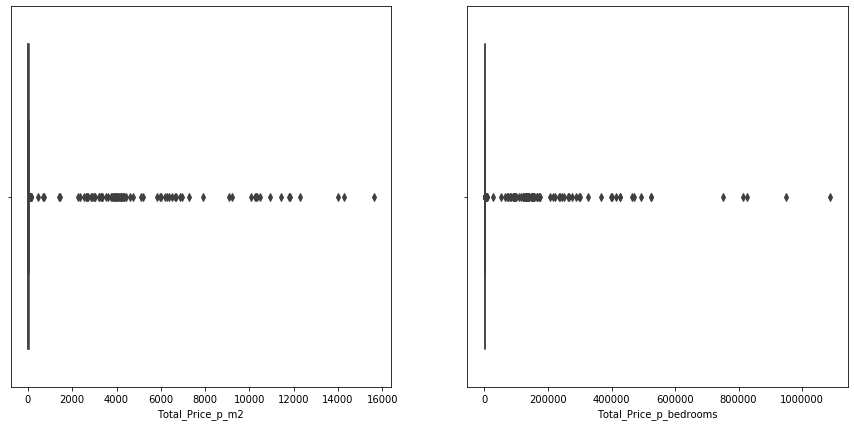

In [8]:
# Create a graph with outliers
f, axes = plt.subplots(1, 2, figsize = (15, 7))

sns.boxplot(x = dataset['Total_Price_p_m2'], ax = axes[0])

sns.boxplot(x = dataset['Total_Price_p_bedrooms'], ax = axes[1])

In [9]:
# Seting Limits

Q1 = dataset['Total_Price_p_m2'].quantile(.25)
Q3 = dataset['Total_Price_p_m2'].quantile(.75)
IIQ = Q3 - Q1
inferior_limit = Q1 - 1.5*IIQ
superior_limit = Q3 + 1.5*IIQ


# Removing Outliers

inside_limit = (dataset['Total_Price_p_m2'] >= inferior_limit) & (dataset['Total_Price_p_m2'] <= superior_limit)
dataset = dataset[inside_limit]
dataset

,lat,lon,area,rent,condofee,IPTU,bedrooms,Total_Price,Total_Price_p_m2,Total_Price_p_bedrooms
9,-19.953305,-43.929241,4775,23000,8000,2700,4,31225.00,6.54,7806.25
10,-19.953305,-43.929241,758,16000,8000,2650,5,24220.83,31.95,4844.17
11,-19.953305,-43.929241,5000,16000,8000,3007,5,24250.58,4.85,4850.12
12,-19.953305,-43.929241,4775,16000,7750,2752,5,23979.33,5.02,4795.87
14,-19.939045,-43.919928,510,18000,4300,1822,4,22451.83,44.02,5612.96
...,...,...,...,...,...,...,...,...,...,...
6979,-19.806149,-43.935746,87,500,60,0,2,560.00,6.44,280.00
6980,-19.821518,-43.927335,110,560,0,90,2,567.50,5.16,283.75
6981,-19.993084,-44.001887,300,550,1,1,1,551.08,1.84,551.08
6982,-19.993084,-44.001887,300,550,1,1,1,551.08,1.84,551.08


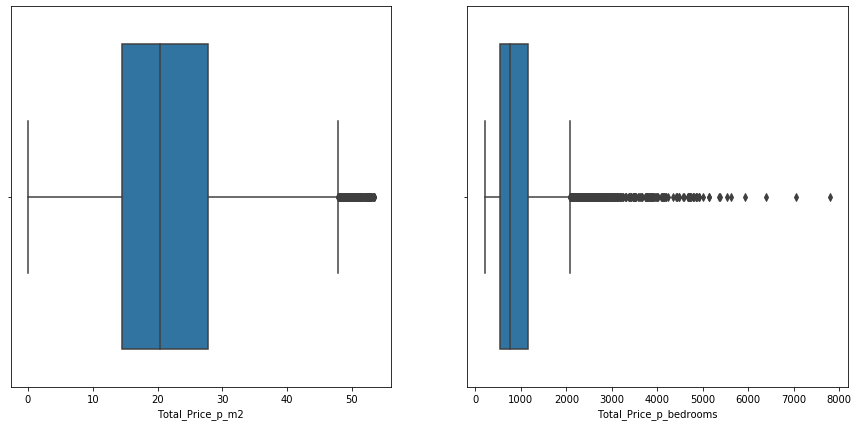

In [10]:
# Create a graph without outliers
f, axes = plt.subplots(1, 2, figsize = (15, 7))

sns.boxplot(x = dataset['Total_Price_p_m2'], ax = axes[0])

sns.boxplot(x = dataset['Total_Price_p_bedrooms'], ax = axes[1])

# 3. GeoDataFrame Apartments

In [11]:
# Creating a Geometry Column

geometry = [Point(x) for x in zip(dataset.lon, dataset.lat)]
crs = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}
geo_data = gpd.GeoDataFrame(dataset, crs = crs, geometry = geometry)

geo_data.head()

,lat,lon,area,rent,condofee,IPTU,bedrooms,Total_Price,Total_Price_p_m2,Total_Price_p_bedrooms,geometry
9,-19.953305,-43.929241,4775,23000,8000,2700,4,31225.00,6.54,7806.25,POINT (-43.92924 -19.95331)
10,-19.953305,-43.929241,758,16000,8000,2650,5,24220.83,31.95,4844.17,POINT (-43.92924 -19.95331)
11,-19.953305,-43.929241,5000,16000,8000,3007,5,24250.58,4.85,4850.12,POINT (-43.92924 -19.95331)
12,-19.953305,-43.929241,4775,16000,7750,2752,5,23979.33,5.02,4795.87,POINT (-43.92924 -19.95331)
14,-19.939045,-43.919928,510,18000,4300,1822,4,22451.83,44.02,5612.96,POINT (-43.91993 -19.93905)


In [12]:
geo_data = geo_data.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs')

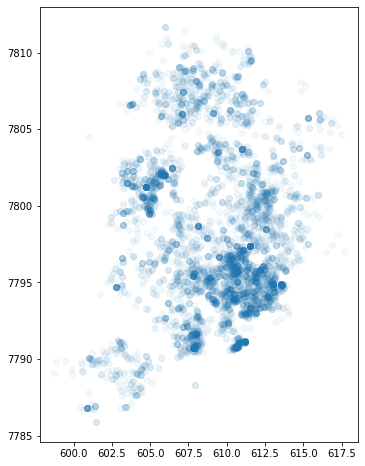

In [13]:
geo_data.plot(figsize=(15, 8), alpha=0.05)

In [17]:
geo_data.to_file('./Output/apartments.shp')